In [1]:
from PIL import Image
from vangogh.evolution import Evolution
from vangogh.fitness import draw_voronoi_image
from vangogh.util import IMAGE_SHRINK_SCALE, REFERENCE_IMAGE
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('classic')
%matplotlib inline

from multiprocess import Pool, cpu_count

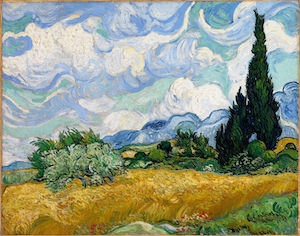

In [2]:
display(REFERENCE_IMAGE)

In [3]:
# Enable to show live rendering of best individual during optimization
display_output = False
# Enable to save progress images at every 50th generation
save_progress = True
# Enable to print verbose output per generation
verbose_output = True

In [4]:
def reporter(time, evo):
    if save_progress or display_output:
        elite = draw_voronoi_image(evo.elite, evo.reference_image.width, evo.reference_image.height, scale=IMAGE_SHRINK_SCALE)
    if display_output:
        clear_output()
        display(elite)
    if save_progress and time["num-generations"] % 50 == 0:
        elite.save(f"./img/van_gogh_intermediate_{evo.seed}_{evo.population_size}_{evo.crossover_method}_{evo.num_points}_{evo.initialization}_{evo.generation_budget}_{time['num-generations']:05d}.png")

def run_algorithm(settings):
    seed, population_size, crossover_method, num_points, initialization, generation_budget, ratio = settings
    start = time()
    
    data = []
    evo = Evolution(num_points,
                    REFERENCE_IMAGE,
                    population_size=population_size,
                    generation_reporter=reporter,
                    crossover_method=crossover_method,
                    seed=seed,
                    initialization=initialization,
                    generation_budget=generation_budget,
                    num_features_mutation_strength=.25,
                    selection_name='tournament_4',
                    verbose=verbose_output,
                    elite_ratio=ratio)
    data = evo.run()
    time_spent = time() - start
    print(f"Done: run {seed} - pop {population_size} - crossover {crossover_method} - num. points {num_points} - initialization {initialization} - in {int(time_spent)} seconds")
    
    return data

## Running a single instance

In [5]:
# %%time
# data = run_algorithm((0, 100, "ONE_POINT", 100, 'RANDOM', 500))

## Running a sweep of settings

In [6]:
%%time

generation_budget = 100
ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
 
data = []
for ratio in ratios:
    for seed in range(1):
        for population_size in (100,):
            for crossover_method in ("ONE_POINT",):
                for initialization in ("RANDOM",):
                    for num_points in (100,):
                        data.extend(run_algorithm((seed, population_size, crossover_method, num_points, initialization, generation_budget, ratio)))

generation: 1 best fitness: 134707 avg. fitness: 142701.96
generation: 2 best fitness: 130342 avg. fitness: 138707.32
generation: 3 best fitness: 127491 avg. fitness: 134387.35
generation: 4 best fitness: 123941 avg. fitness: 130860.17
generation: 5 best fitness: 123208 avg. fitness: 128864.12
generation: 6 best fitness: 119181 avg. fitness: 126379.74
generation: 7 best fitness: 119181 avg. fitness: 124298.73
generation: 8 best fitness: 118549 avg. fitness: 121943.24
generation: 9 best fitness: 114174 avg. fitness: 118385.1
generation: 10 best fitness: 113358 avg. fitness: 116570.8
generation: 11 best fitness: 110349 avg. fitness: 114474.26
generation: 12 best fitness: 110325 avg. fitness: 112908.73
generation: 13 best fitness: 109798 avg. fitness: 111451.5
generation: 14 best fitness: 108822 avg. fitness: 110257.18
generation: 15 best fitness: 106723 avg. fitness: 109505.36
generation: 16 best fitness: 105946 avg. fitness: 108556.35
generation: 17 best fitness: 104954 avg. fitness: 10

## Evaluating the results

In [7]:
df = pd.DataFrame(data)
df["time-elapsed"] = df["time-elapsed"].round(0)

Final result using ratio: 0.0 is [78568.] -> improvement: [-84.9398583]
Final result using ratio: 0.1 is [78568.] -> improvement: [-84.9398583]
Final result using ratio: 0.2 is [76759.] -> improvement: [-80.68168444]
Final result using ratio: 0.3 is [75492.] -> improvement: [-77.69931502]
Final result using ratio: 0.4 is [82254.] -> improvement: [-93.61627004]
Final result using ratio: 0.5 is [79970.] -> improvement: [-88.24000188]
Final result using ratio: 0.6 is [75281.] -> improvement: [-77.20264576]


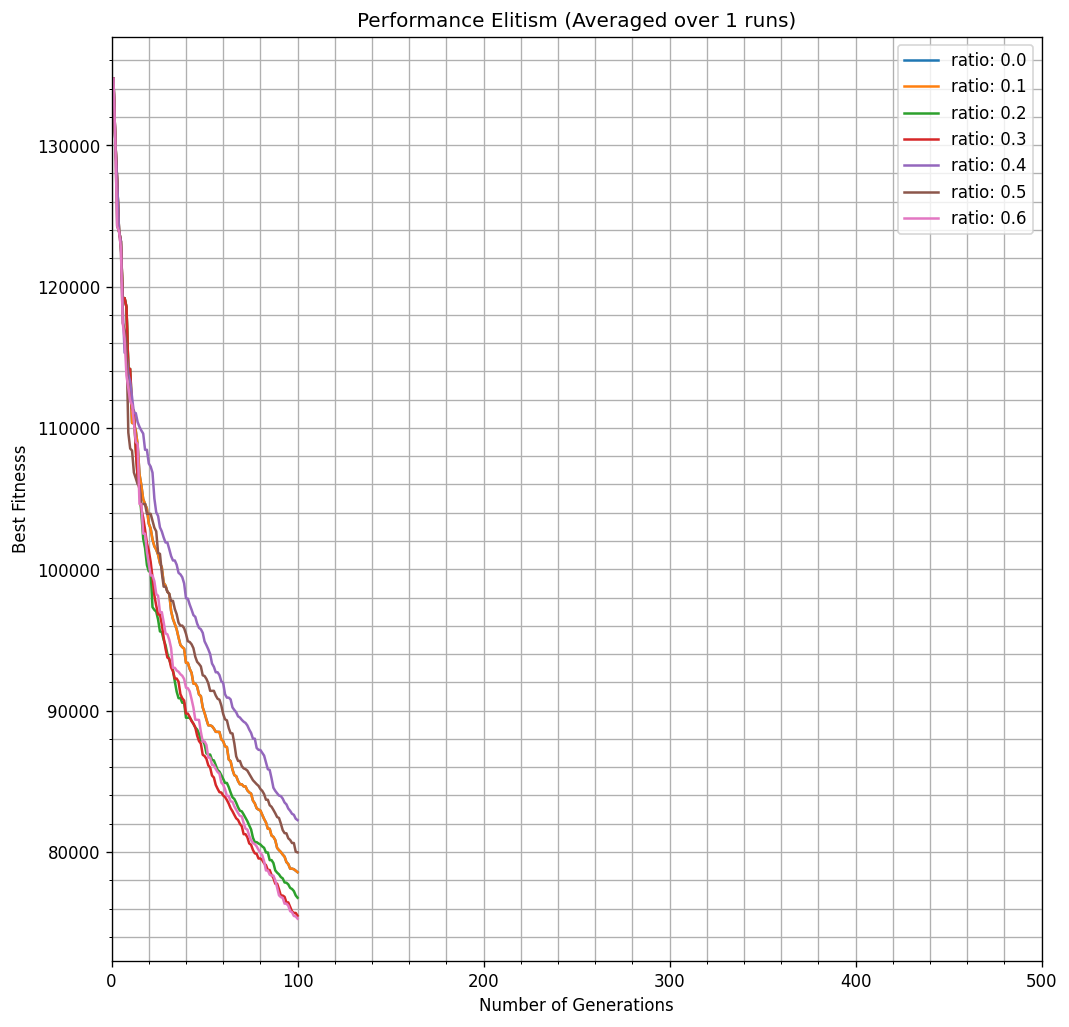

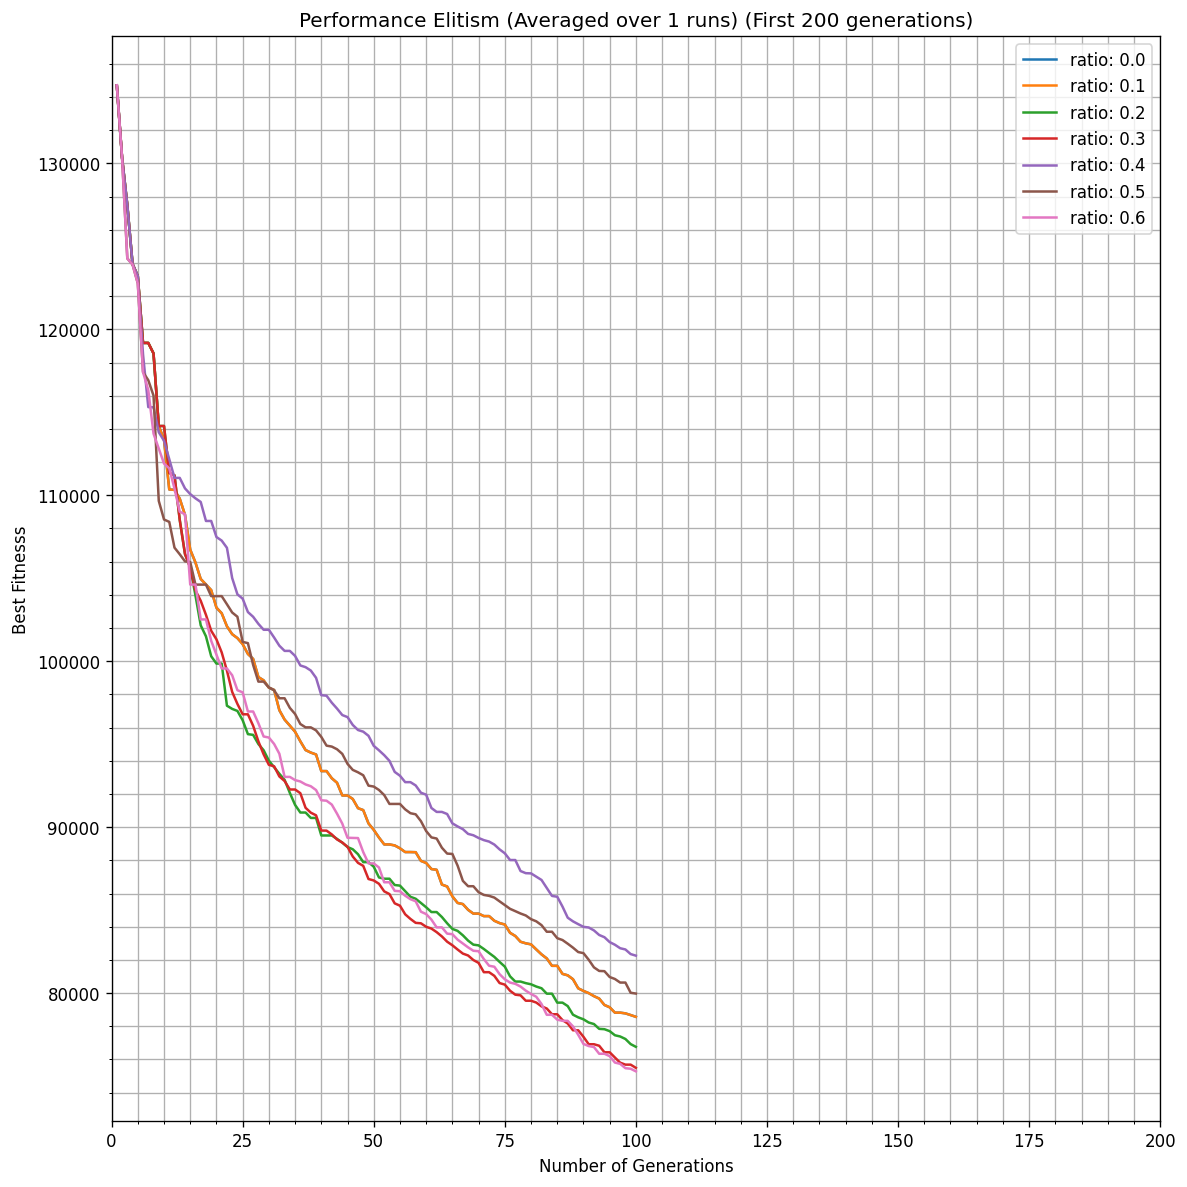

In [14]:
plt.rcParams.update(plt.rcParamsDefault)

fig, ax = plt.subplots(figsize=(10,10), dpi=120)
fig1, ax1 = plt.subplots(figsize=(10,10), dpi=120)
ax_lst = [ax, ax1]
runs_per_ratio = df["elitism-ratio"].value_counts()[0]//generation_budget
color_palette = plt.cm.tab10(np.linspace(0, 1, len(ratios)))
cut_off = 200

for i, ratio in enumerate(ratios):
    ratio_df = df[df["elitism-ratio"] == ratio]
    avg = ratio_df.groupby("num-generations")["best-fitness"].mean()
    avg = pd.DataFrame(avg)

    ax.plot(avg.index, avg.values, label=f"ratio: {ratio}")
    ax1.plot(avg.index[0:cut_off], avg.values[0:cut_off], label=f"ratio: {ratio}")
    #ax.plot(avg.index, avg.values, color=color_palette[i], label=f"ratio: {ratio}")
    final_y = avg.values[-1]
    print(f"Final result using ratio: {ratio} is {final_y} -> improvement: {(42483 - final_y)/42483 * 100}")
ax.set_title(f"Performance Elitism (Averaged over {runs_per_ratio} runs)")
ax.set_xlim((0,500))
ax1.set_title(f"Performance Elitism (Averaged over {runs_per_ratio} runs) (First {cut_off} generations)")
ax1.set_xlim((0,cut_off))

for a in ax_lst:
    a.legend()
    a.set_xlabel("Number of Generations")
    a.set_ylabel("Best Fitnesss")
    #plt.xlim((0, 150))
    a.minorticks_on()
    a.grid(which="both")
plt.tight_layout()
plt.show()

Ratio 0.0: Average CR = -567.060606060606 Final CR = -106.0
Ratio 0.1: Average CR = -567.060606060606 Final CR = -106.0
Ratio 0.2: Average CR = -585.3333333333334 Final CR = -165.0
Ratio 0.3: Average CR = -598.1313131313132 Final CR = -194.0
Ratio 0.4: Average CR = -529.8282828282828 Final CR = -96.0
Ratio 0.5: Average CR = -552.89898989899 Final CR = -48.0
Ratio 0.6: Average CR = -600.2626262626262 Final CR = -157.0


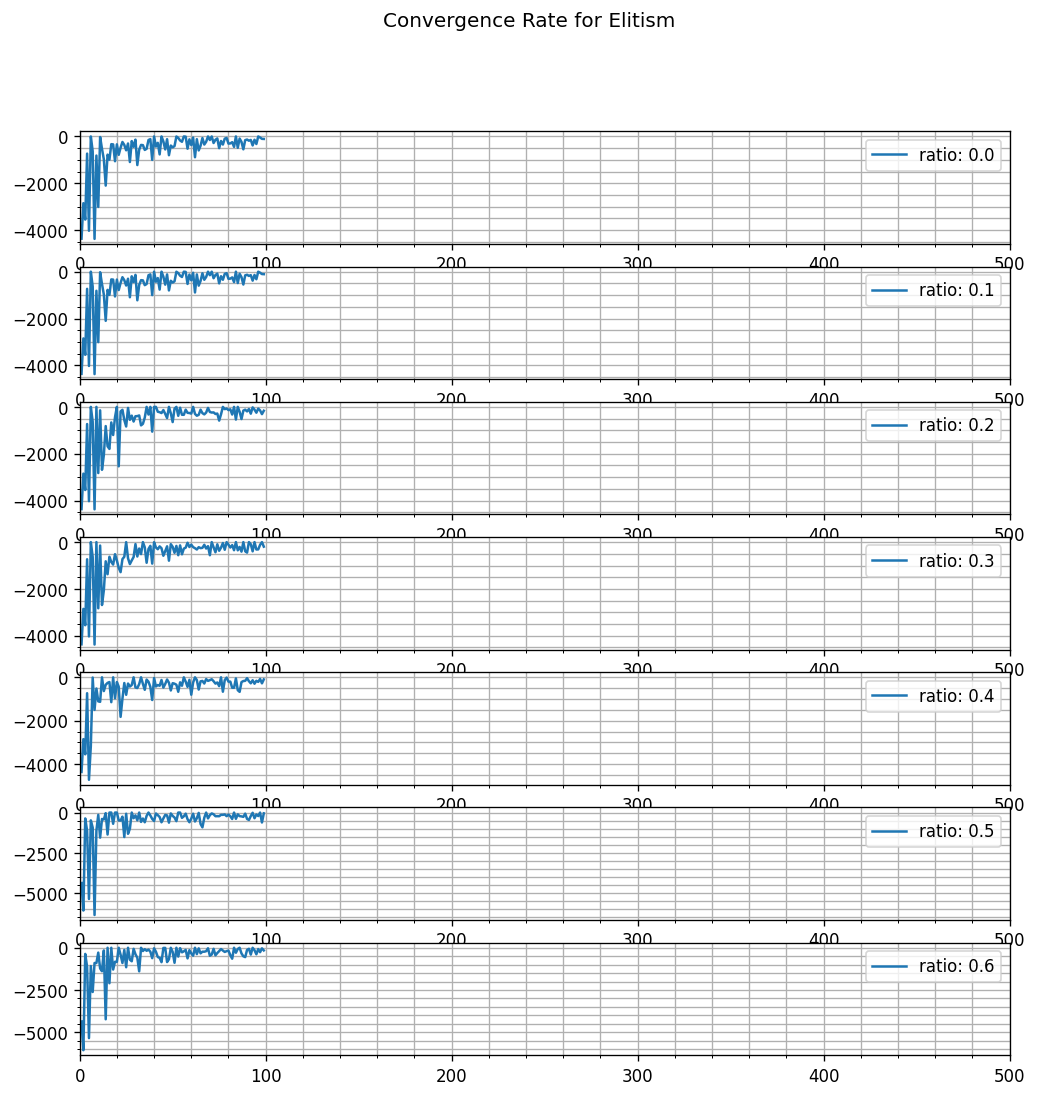

In [16]:
plt.rcParams.update(plt.rcParamsDefault)

fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(10,10), dpi=120)
runs_per_ratio = df["elitism-ratio"].value_counts()[0]//generation_budget

for i, ratio in enumerate(ratios):
    ratio_df = df[df["elitism-ratio"] == ratio]
    avg = ratio_df.groupby("num-generations")["best-fitness"].mean()
    avg = pd.DataFrame(avg)
    print(f"Ratio {ratio}: Average CR = {np.average(np.diff(avg.values.squeeze()))} Final CR = {np.diff(avg.values.squeeze())[-1]}")

    ax[i].plot(avg.index[:-1], np.diff(avg.values.squeeze()), label=f"ratio: {ratio}")
    ax[i].set_xlim((0,500))
    ax[i].legend()
    #plt.xlim((0, 150))
    ax[i].minorticks_on()
    ax[i].grid(which="both")

fig.suptitle("Convergence Rate for Elitism")
plt.show()

## Displaying the best instances over time

In [10]:
def show_progress_over_time(settings, selection=None, grid=(5,4)):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=grid,
                     axes_pad=0.1,  # pad between axes
                     )

    if selection is None:
        selection = range(50, generation_budget + 50, 50)
    
    img_arr = [Image.open((f"./img/van_gogh_intermediate_{seed}_{population_size}_{crossover_method}_{num_points}_{initialization}_{generation_budget}_{i:05d}.png")) for i in selection]
    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

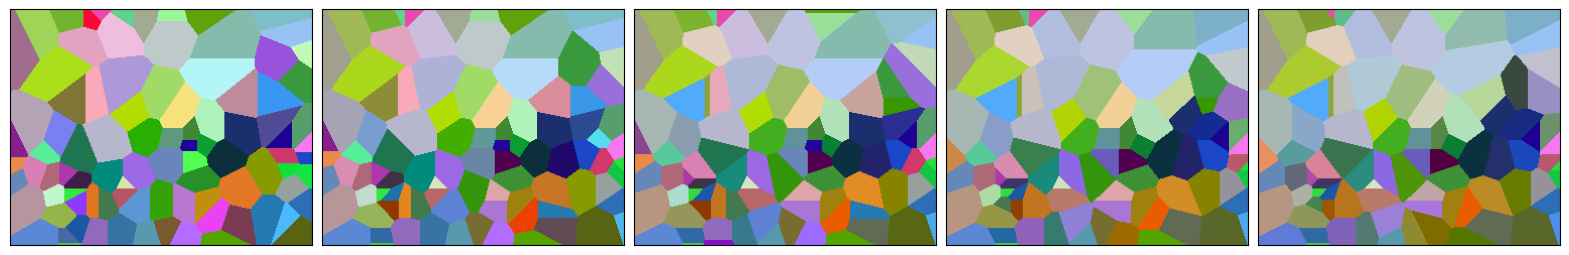

In [11]:
show_progress_over_time((0, 100, 'ONE_POINT', 100, "RANDOM", 500), grid=(1,5))